In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from keras.applications import VGG16
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint
from sklearn.metrics import confusion_matrix, classification_report

In [2]:
# Paths and parameters
best_cars_model_path = 'best_cars_model.h5'
train_cars_dataset_path = 'data/cars_train/train'
test_cars_dataset_path = 'data/cars_train/test'
mean = np.array([0.4708, 0.4602, 0.4550])
std = np.array([0.2593, 0.2584, 0.2634])

In [3]:
# Data augmentation and preprocessing
train_datagen = ImageDataGenerator(
    rescale=1./255,
    featurewise_center=True,
    featurewise_std_normalization=True,
    horizontal_flip=True,
    rotation_range=20,
    shear_range=0.2,
    zoom_range=0.2,
    brightness_range=[0.5, 1.5]
)
train_datagen.mean = mean
train_datagen.std = std

train_generator = train_datagen.flow_from_directory(
    train_cars_dataset_path,
    target_size=(64, 64),
    batch_size=512,
    class_mode='categorical'
)

test_datagen = ImageDataGenerator(
    rescale=1./255,
    featurewise_center=True,
    featurewise_std_normalization=True
)
test_datagen.mean = mean
test_datagen.std = std

test_generator = test_datagen.flow_from_directory(
    test_cars_dataset_path,
    target_size=(64, 64),
    batch_size=512,
    class_mode='categorical',
    shuffle=False
)

Found 6442 images belonging to 196 classes.
Found 1702 images belonging to 196 classes.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Labels: [ 55 181   7 100  26 113  45 116  81 154 159 182 187  36  39 136  65   9
 135  41  26 114  14  55  45 191 175 171 164 137 174   4 153 146  57  17
  93 173  52  70  91 147 104 187 112 191  13  35 139  84  69 174 168 195
  64  27  69 123  94  39 158  40  15 166  30   0   8  34 150 130  60  92
 135  62 183  62 148 139 176 145 154 183 111  90 101 145  36  24  48 157
  94 194 138 144 177 183   9  20 172  97  71 140 114  83 175  86  69 193
  92 175  94 175 133   0 150  97 172  41  82  76 120 100 114  66 185   1
 148 133 156 112   9 169  71 144  39 165 120  45 111 173  31  32  15 167
 175 188 155   1 129 168  70 168  62 106 102 178 186 116  81  67  11 158
  43  10 129  53  59  97   3  11  91 148  35  84  48 193 161  39 142 174
  73  83 160 178   7  98 108  97 170   7 111 164 145  68 186 133 184  43
 124  20 144  60  55 158 114 178  97  14 183  39 157 101   0  38  84  28
  45   5 173 124 186 138 131  34  16  43  30  41 101  87 106 179 141 127
  60 189  10  91  96  91  70 192  98  64  1

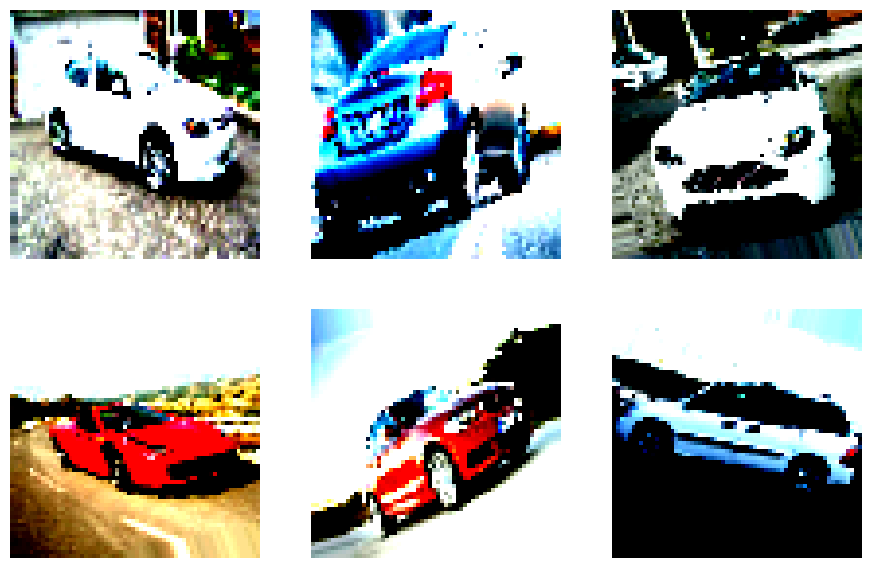

In [4]:
# Display some images
def show_transformed_images(generator, num_images=6):
    images, labels = next(generator)
    print(f"Labels: {np.argmax(labels, axis=1)}")
    plt.figure(figsize=(11,11))
    for i in range(num_images):
        plt.subplot(3, 3, i+1)
        plt.imshow(images[i])
        plt.axis('off')
    plt.show()

show_transformed_images(train_generator)

In [5]:
# Defining CNN model
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(64, 64, 3))
num_classes = len(train_generator.class_indices)

for layer in base_model.layers:
  layer.trainable = False

model = Sequential([ 
  base_model,
  Flatten(),
  Dense(256, activation='relu'),
  Dropout(0.5),
  Dense(num_classes, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 2, 2, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 256)               524544    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 196)               50372     
                                                                 
Total params: 15289604 (58.33 MB)
Trainable params: 574916 (2.19 MB)
Non-trainable params: 14714688 (56.13 MB)
_________________________________________________________________


In [6]:
# Callbacks for saving the best model
checkpoint = ModelCheckpoint(best_cars_model_path, monitor='val_accuracy', save_best_only=True, mode='max')

In [7]:
# Train the model
history = model.fit(
  train_generator,
  epochs=100,
  validation_data=test_generator,
  callbacks=[checkpoint],
)

Epoch 1/100
13/13 [==============================] - 81s 6s/step - loss: 5.3759 - accuracy: 0.0062 - val_loss: 5.2681 - val_accuracy: 0.0053
Epoch 2/100


c:\Users\rauls\anaconda3\envs\directML\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


13/13 [==============================] - 77s 6s/step - loss: 5.2611 - accuracy: 0.0093 - val_loss: 5.2569 - val_accuracy: 0.0106
Epoch 3/100
13/13 [==============================] - 76s 6s/step - loss: 5.2448 - accuracy: 0.0087 - val_loss: 5.2343 - val_accuracy: 0.0071
Epoch 4/100
13/13 [==============================] - 79s 6s/step - loss: 5.2108 - accuracy: 0.0129 - val_loss: 5.2056 - val_accuracy: 0.0153
Epoch 5/100
13/13 [==============================] - 75s 6s/step - loss: 5.1688 - accuracy: 0.0183 - val_loss: 5.1587 - val_accuracy: 0.0188
Epoch 6/100
13/13 [==============================] - 75s 6s/step - loss: 5.1012 - accuracy: 0.0233 - val_loss: 5.1087 - val_accuracy: 0.0270
Epoch 7/100
13/13 [==============================] - 75s 6s/step - loss: 5.0396 - accuracy: 0.0292 - val_loss: 5.0540 - val_accuracy: 0.0335
Epoch 8/100
13/13 [==============================] - 77s 6s/step - loss: 4.9721 - accuracy: 0.0355 - val_loss: 4.9931 - val_accuracy: 0.0358
Epoch 9/100
13/13 [======

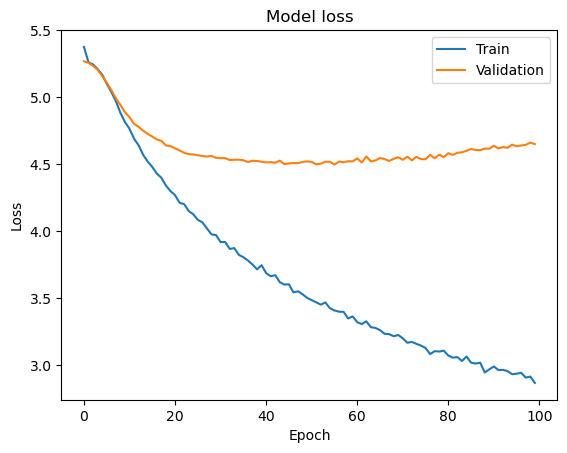

In [8]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

In [9]:
# Load the best model
best_model = load_model(best_cars_model_path)

# Evaluation
train_loss, train_acc = best_model.evaluate(train_generator, verbose=0)
print(f'Train loss: {train_loss}')
print(f'Train accuracy: {train_acc}')

test_loss, train_acc = best_model.evaluate(test_generator, verbose=0)
print(f'Test loss: {test_loss}')
print(f'Test accuracy: {train_acc}')

Train loss: 2.280421018600464
Train accuracy: 0.5478112101554871
Test loss: 4.614823341369629
Test accuracy: 0.0987074002623558


In [10]:
# Prediction and metrics
predictions = best_model.predict(test_generator)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = test_generator.classes

4/4 [==============================] - 17s 4s/step


In [11]:
print('Confusion Matrix')
confusion_mtx = confusion_matrix(true_classes, predicted_classes)
confusion_mtx

Confusion Matrix


array([[4, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 1, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 1, 0, 4]], dtype=int64)

In [12]:
print('Classification Report')
print(classification_report(true_classes, predicted_classes))

Classification Report
              precision    recall  f1-score   support

           0       0.22      0.44      0.30         9
           1       0.00      0.00      0.00         9
           2       0.00      0.00      0.00         7
           3       0.00      0.00      0.00         9
           4       0.25      0.33      0.29         9
           5       0.00      0.00      0.00         9
           6       0.00      0.00      0.00         8
           7       0.33      0.11      0.17         9
           8       0.17      0.11      0.13         9
           9       1.00      0.14      0.25         7
          10       0.08      0.12      0.10         8
          11       0.60      0.33      0.43         9
          12       0.00      0.00      0.00         9
          13       0.07      0.11      0.09         9
          14       0.00      0.00      0.00         9
          15       0.00      0.00      0.00         8
          16       0.06      0.11      0.08         9
     

c:\Users\rauls\anaconda3\envs\directML\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\rauls\anaconda3\envs\directML\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\rauls\anaconda3\envs\directML\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
